Exercise 4: Image Compression
=======================

To complete the exercise, follow the instructions and complete the missing code and write the answers where required.  All points, except the ones marked with **(N points)** are mandatory. The optional tasks require more independet work and some extra effort. Without completing them you can get at most 75 points for the exercise (the total number of points is 100 and results in grade 10). Sometimes there are more optional exercises and you do not have to complete all of them, you can get at most 100 points.

## Introduction
In this exercise, you will implement parts of the JPEG pipeline for image compression. The method is based on performing the <a href="https://en.wikipedia.org/wiki/Discrete_Fourier_transform">discrete cosine transform (DCT)</a> on 8x8 blocks, quantizing the resulting coefficients, then losslessly compressing them via entropy encoding. You will first familiarize yourself with the calculation and properties of the DCT by using it on 1D signals, then use its 2D variant to transform and reconstruct images. Finally, you will implement a rough version of the JPEG algorithm and check the reductions in space and quality of the compressed images.

In [1]:
%matplotlib notebook

# Run this cell to download the data used in this exercise
import zipfile, urllib.request, io
zipfile.ZipFile(io.BytesIO(urllib.request.urlopen("http://box.vicos.si/borja/mms/exercise4.zip").read())).extractall()

In [2]:
%matplotlib notebook

# Necessary imports
from matplotlib import pyplot as plt
import numpy as np
from skimage import data, io, transform

from operator import itemgetter, attrgetter
import queue

Assignment 1: 1D DCT
--------

The discrete cosine transform used in JPEG standard is called DCT-II. The process expresses a (finite) sequence of data points as a sum of cosines with different frequencies (called basis functions). The result is a list of coefficients which can be used to reconstruct the original data. The most commonly used is DCT-II, also called "the DCT". Its inverse, DCT-III is called "the inverse DCT". Their formulas are as follows:

\begin{equation}
X_k = \sum_{n=0}^{N-1}x_n \cos{\Big(\frac{\pi}{N}\Big(n+\frac{1}{2}\Big)k\Big)}; \quad k = 0,\dots, N-1,\\
x_k = \frac{1}{N}X_0+\sum_{n=1}^{N-1}\frac{2}{N} \ X_n \cos{\Big(  \frac{\pi}{N}\ n\ \Big(  k+\frac{1}{2}  \Big)  \Big)}; \quad k = 0,\dots, N-1
\end{equation}

where $x_n$ denotes the $n$-th element of the input signal, while $N$ denotes the total number of elements of the input signal.



a) Implement 1D DCT transform and its inverse. Implement the ``my_dct`` and ``my_idct`` functions that receive a signal and return the DCT coefficients (the sizes must match). Use the above formulas. Take note that these are the basic formulas. In practice, scaling factors are used to allow the transform to be expressed as matrix multiplication (see point <i>(d)</i>). You can test the correctness of your implementation by transforming a signal to frequency domain and back again. The result should be equal to the input signal (up to machine precision).

In [3]:
def my_dct(input_signal):
    # TODO: Compute the 1D DCT transform of the 'input_signal'
    N = len(input_signal)
    n = np.arange(0, N, 1)
    K = np.arange(0, N, 1)
    X = np.zeros(N)
    for k in K:
        for ix in n:
            X[k] += input_signal[ix]*np.cos((np.pi/N)*(ix+0.5)*k)
    return np.array(X)
    pass

test_input = [1, 5, 0, 4]
#should generate output: [1.00000000e+01 -8.58221436e-01 -4.44089210e-16 -5.76744796e+00]
out = my_dct(test_input)
print(out)

[ 1.00000000e+01 -8.58221436e-01 -4.44089210e-16 -5.76744796e+00]


In [4]:
def my_idct(input_signal):
    # TODO: Compute the inverse of the 1D DCT transform passed as 'input_signal'
    N = len(input_signal)
    k = np.arange(0, N, 1)
    n = np.arange(1, N, 1)
    x = np.ones(len(k))*(input_signal[0]/N)
    for ix in k:
        cos = np.cos((np.pi/N)*n*(ix + 0.5));
        x[ix] += (2/N)*np.dot(input_signal[1:N], cos)
    return x
    pass
print(my_idct(out))

[1.0000000e+00 5.0000000e+00 4.4408921e-16 4.0000000e+00]


b) In DCT, the signal is expressed as a sum of cosines with differing frequencies. Take a sensible range of numbers (e.g. $[-\pi, \pi]$) and plot the basis functions. The number of basis functions must equal the number of data points in the chosen interval.

The result should look like this:
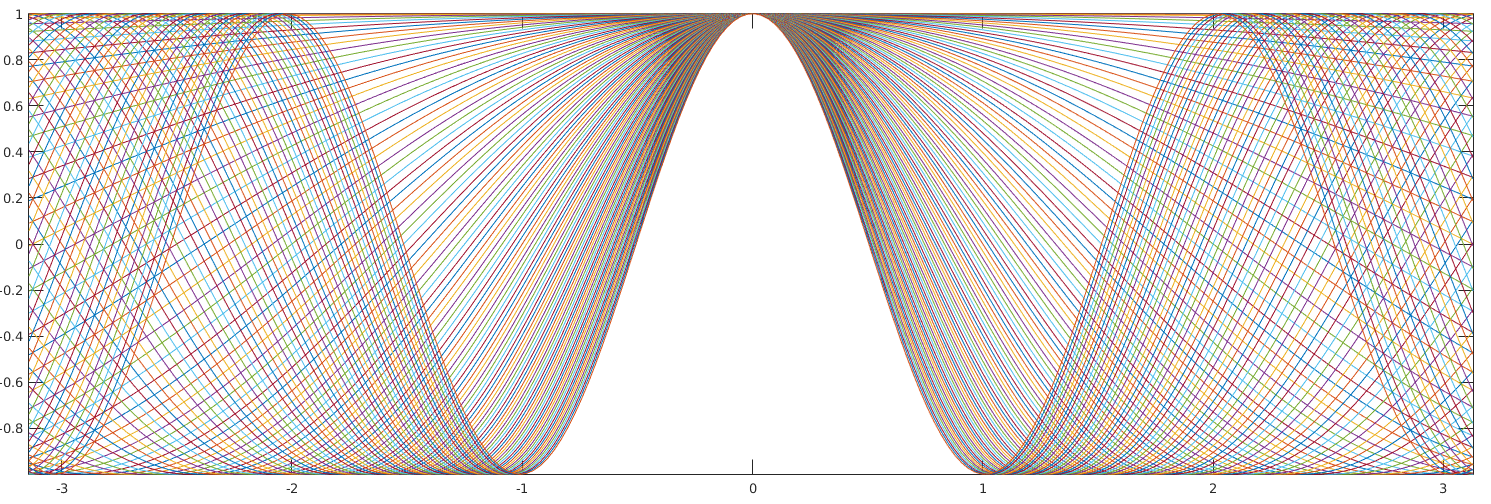

<IPython.core.display.Javascript object>


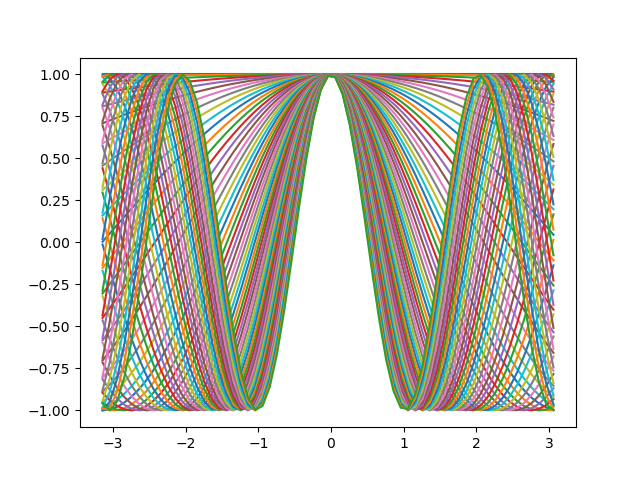

In [5]:
# TODO: Plot the basis functions
sensible_range = np.arange(-np.pi, np.pi, 0.1)
N = len(sensible_range)
plt.figure()
n = np.arange(0, N, 1)
for i in n:
    plt.plot(sensible_range, np.cos((np.pi/N)*(sensible_range)*i))

plt.show()

c) <b>(10 points)</b> Visualize the signal reconstruction from the DCT coefficients. Perform the DCT on a chosen signal (to make the process easier to follow, you should use a well known function), then multiply the resulting coefficient by the appropriate basis function for each of the data points and add it to the result. Plot the intermediate result at a few steps. If performed correctly, the signal should in the end be fully reconstructed. Also plot the error between the original and the reconstuction for some of the steps.


629


<IPython.core.display.Javascript object>


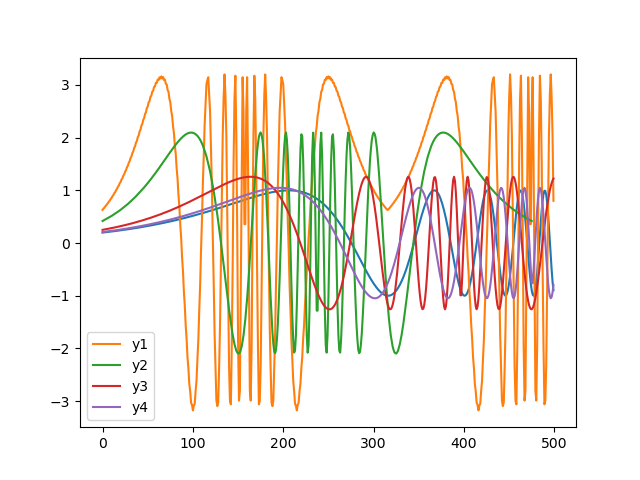

In [6]:
# TODO (+10 points)
# Hint 1: Implement a new function that performs inverse DCT up to the specified num basis
# Hint 2: Try reconstructing signal y = np.sin( np.exp(x) * 0.2) What do you notice
def my_idct_limita(input_signal, limita):
    # TODO: Compute the inverse of the 1D DCT transform passed as 'input_signal'
    signal = input_signal[:limita]
    N = len(signal)
    k = np.arange(0, N, 1)
    n = np.arange(1, N, 1)
    x = np.ones(len(k))*(signal[0]/N)
    for indeks in k:
        cos = np.cos((np.pi/N)*n*(indeks+0.5))
        x[indeks] += (2/N)*np.dot(signal[1:N], cos)
    return x



x = np.arange(0, 2*np.pi, 0.01)
y = np.sin( np.exp(x) * 0.2)
y_dct = my_dct(y)

r=500/len(y)

y1 = my_idct_limita(y_dct, 200)[:int(200*r)]
y2 = my_idct_limita(y_dct, 300)[:int(300*r)]
y3 = my_idct_limita(y_dct, 500)[:int(500*r)]
y4 = my_idct_limita(y_dct, 600)[:int(600*r)]

y1 = np.concatenate((y1, y1[::-1]))
y1 = np.concatenate((y1,y1))

y2 = np.concatenate((y2, y2[::-1]))

y3 = np.concatenate((y3, y3[::-1]))

y4 = np.concatenate((y4, y4[::-1]))
print(len(y))

plt.figure()
plt.plot(y[:500])
plt.plot(y1[:500], label="y1")
plt.plot(y2[:500], label="y2")
plt.plot(y3[:500], label="y3")
plt.plot(y4[:500], label="y4")
plt.legend()
plt.show()

d) <b>(5 points)</b> As mentioned above, the first term ($X_0$) of the DCT is sometimes multiplied by $\frac{1}{\sqrt{2}}$ and the resulting matrix is multiplied by an overall scale factor of $\sqrt{\frac{2}{N}}$. This makes the matrix orthogonal and allows the DCT (and the IDCT) to be performed by matrix multiplication. Write a ``dct_coef`` function that takes a size $N$ and returns a $N\times N$ matrix with the DCT coefficients. If the matrix is scaled correctly it should be orthogonal (i.e. $\mathbf{M}\mathbf{M}^\top=\mathbf{I}$). You can check the implementation details for scaling on <a href="https://en.wikipedia.org/wiki/Discrete_cosine_transform#DCT-II">Wikipedia</a>. The DCT can then be calculated by multiplying a signal $x$ by the DCT coefficient matrix $\mathbf{M}$. The same holds for the IDCT, except that it requires multiplication by the transpose of the matrix $\mathbf{M}$.

\begin{equation}
y = \mathbf{M}x^\top \\
\hat{x} = (\mathbf{M}^\top y)^\top
\end{equation}

In [27]:
def dct_coef(N=8):
    # TODO (+5 points)
    pass

## Assignment 2: 2D DCT

The DCT on two-dimensional data can be performed either by first calculating the 1D DCT on matrix rows and then on matrix columns (or vice versa) or by applying the formula directly.

\begin{equation}
X_{k_1,k_2} = \sum_{n_1=0}^{N_1-1} \sum_{n_2=0}^{N_2-1} x_{n_1,n_2} \cos{\bigg(  \frac{\pi}{N_1} \Big( n_1 + \frac{1}{2} \Big) k_1 \bigg)} \cos{\bigg(  \frac{\pi}{N_2} \Big( n_2 + \frac{1}{2} \Big) k_2 \bigg) \quad k_1 = 0,\dots, N_1-1 \quad k_2 = 0,\dots, N_2-1\\}
\end{equation}

where $x_{n_1,n_2}$ denotes the element at $n_1$-th row and $n_2$-th column of the input matrix, while $N_1$ and $N_2$ denote the number of rows and the number of columns of the input matrix, respectively.

a) Implement the ``my_dct2`` and ``my_idct2`` functions that perform the DCT and IDCT on 2D matrices.

In [7]:
"""def my_dct2(input_matrix):
    # TODO: Compute the 2D DCT transform of the input matrix 
    N1 = len(input_matrix)
    N2 = len(input_matrix[0])
    K1 = np.arange(0, N1, 1)
    K2 = np.arange(0, N2, 1)
    n1 = K1
    n2 = K2
    X = np.zeros((N1, N2))
    for k1 in K1:
        cos1 = np.cos((np.pi/N1)*(n1+0.5)*k1)
        for k2 in K2:
            cos2 = np.cos((np.pi/N2)*(n2+0.5)*k2)
            cos3 = np.multiply(cos1, cos2)
            X[k1][k2] = np.dot(input_matrix[k1], cos3)
    return X
    pass"""

def my_dct2(input_matrix):
    # TODO: Compute the 2D DCT transform of the input matrix 
    
    N = len(input_matrix)
    M = len(input_matrix[0])
    
    Y = []
    
    for i in range(0, M):
        Y.append(my_dct(input_matrix[:,i]))

    for i in range(0, N):
        np.transpose(my_dct(np.array(Y[i])))
        
    return np.array(Y)
    pass

Y = np.array([[1,2,3,4],
             [5,6,7,8],
             [9,10,11,12],
             [13,14,15,16]])

result = my_dct2(Y)
print(result)

[[ 2.80000000e+01 -1.26172881e+01 -3.55271368e-15 -8.96683058e-01]
 [ 3.20000000e+01 -1.26172881e+01 -3.55271368e-15 -8.96683058e-01]
 [ 3.60000000e+01 -1.26172881e+01 -3.55271368e-15 -8.96683058e-01]
 [ 4.00000000e+01 -1.26172881e+01 -3.55271368e-15 -8.96683058e-01]]


In [8]:
from copy import copy, deepcopy

def my_idct2(input_matrix):
    # TODO: Compute the inverse 2D DCT tranformation of the input matrix
    N = len(input_matrix)
    M = len(input_matrix[0])
    
    Y = []
    
    for i in range(0, M):
        np.transpose(my_idct(input_matrix[i]))

    for i in range(0, N):
        Y.append(my_idct(input_matrix[i]))
        
    return np.array(np.transpose(Y))
    pass

y_idct2 = my_idct2(result)
print(y_idct2)

[[ 1.  2.  3.  4.]
 [ 5.  6.  7.  8.]
 [ 9. 10. 11. 12.]
 [13. 14. 15. 16.]]


b) <b>(5 points)</b> Plot the 2D basis functions.

The result should look like this:
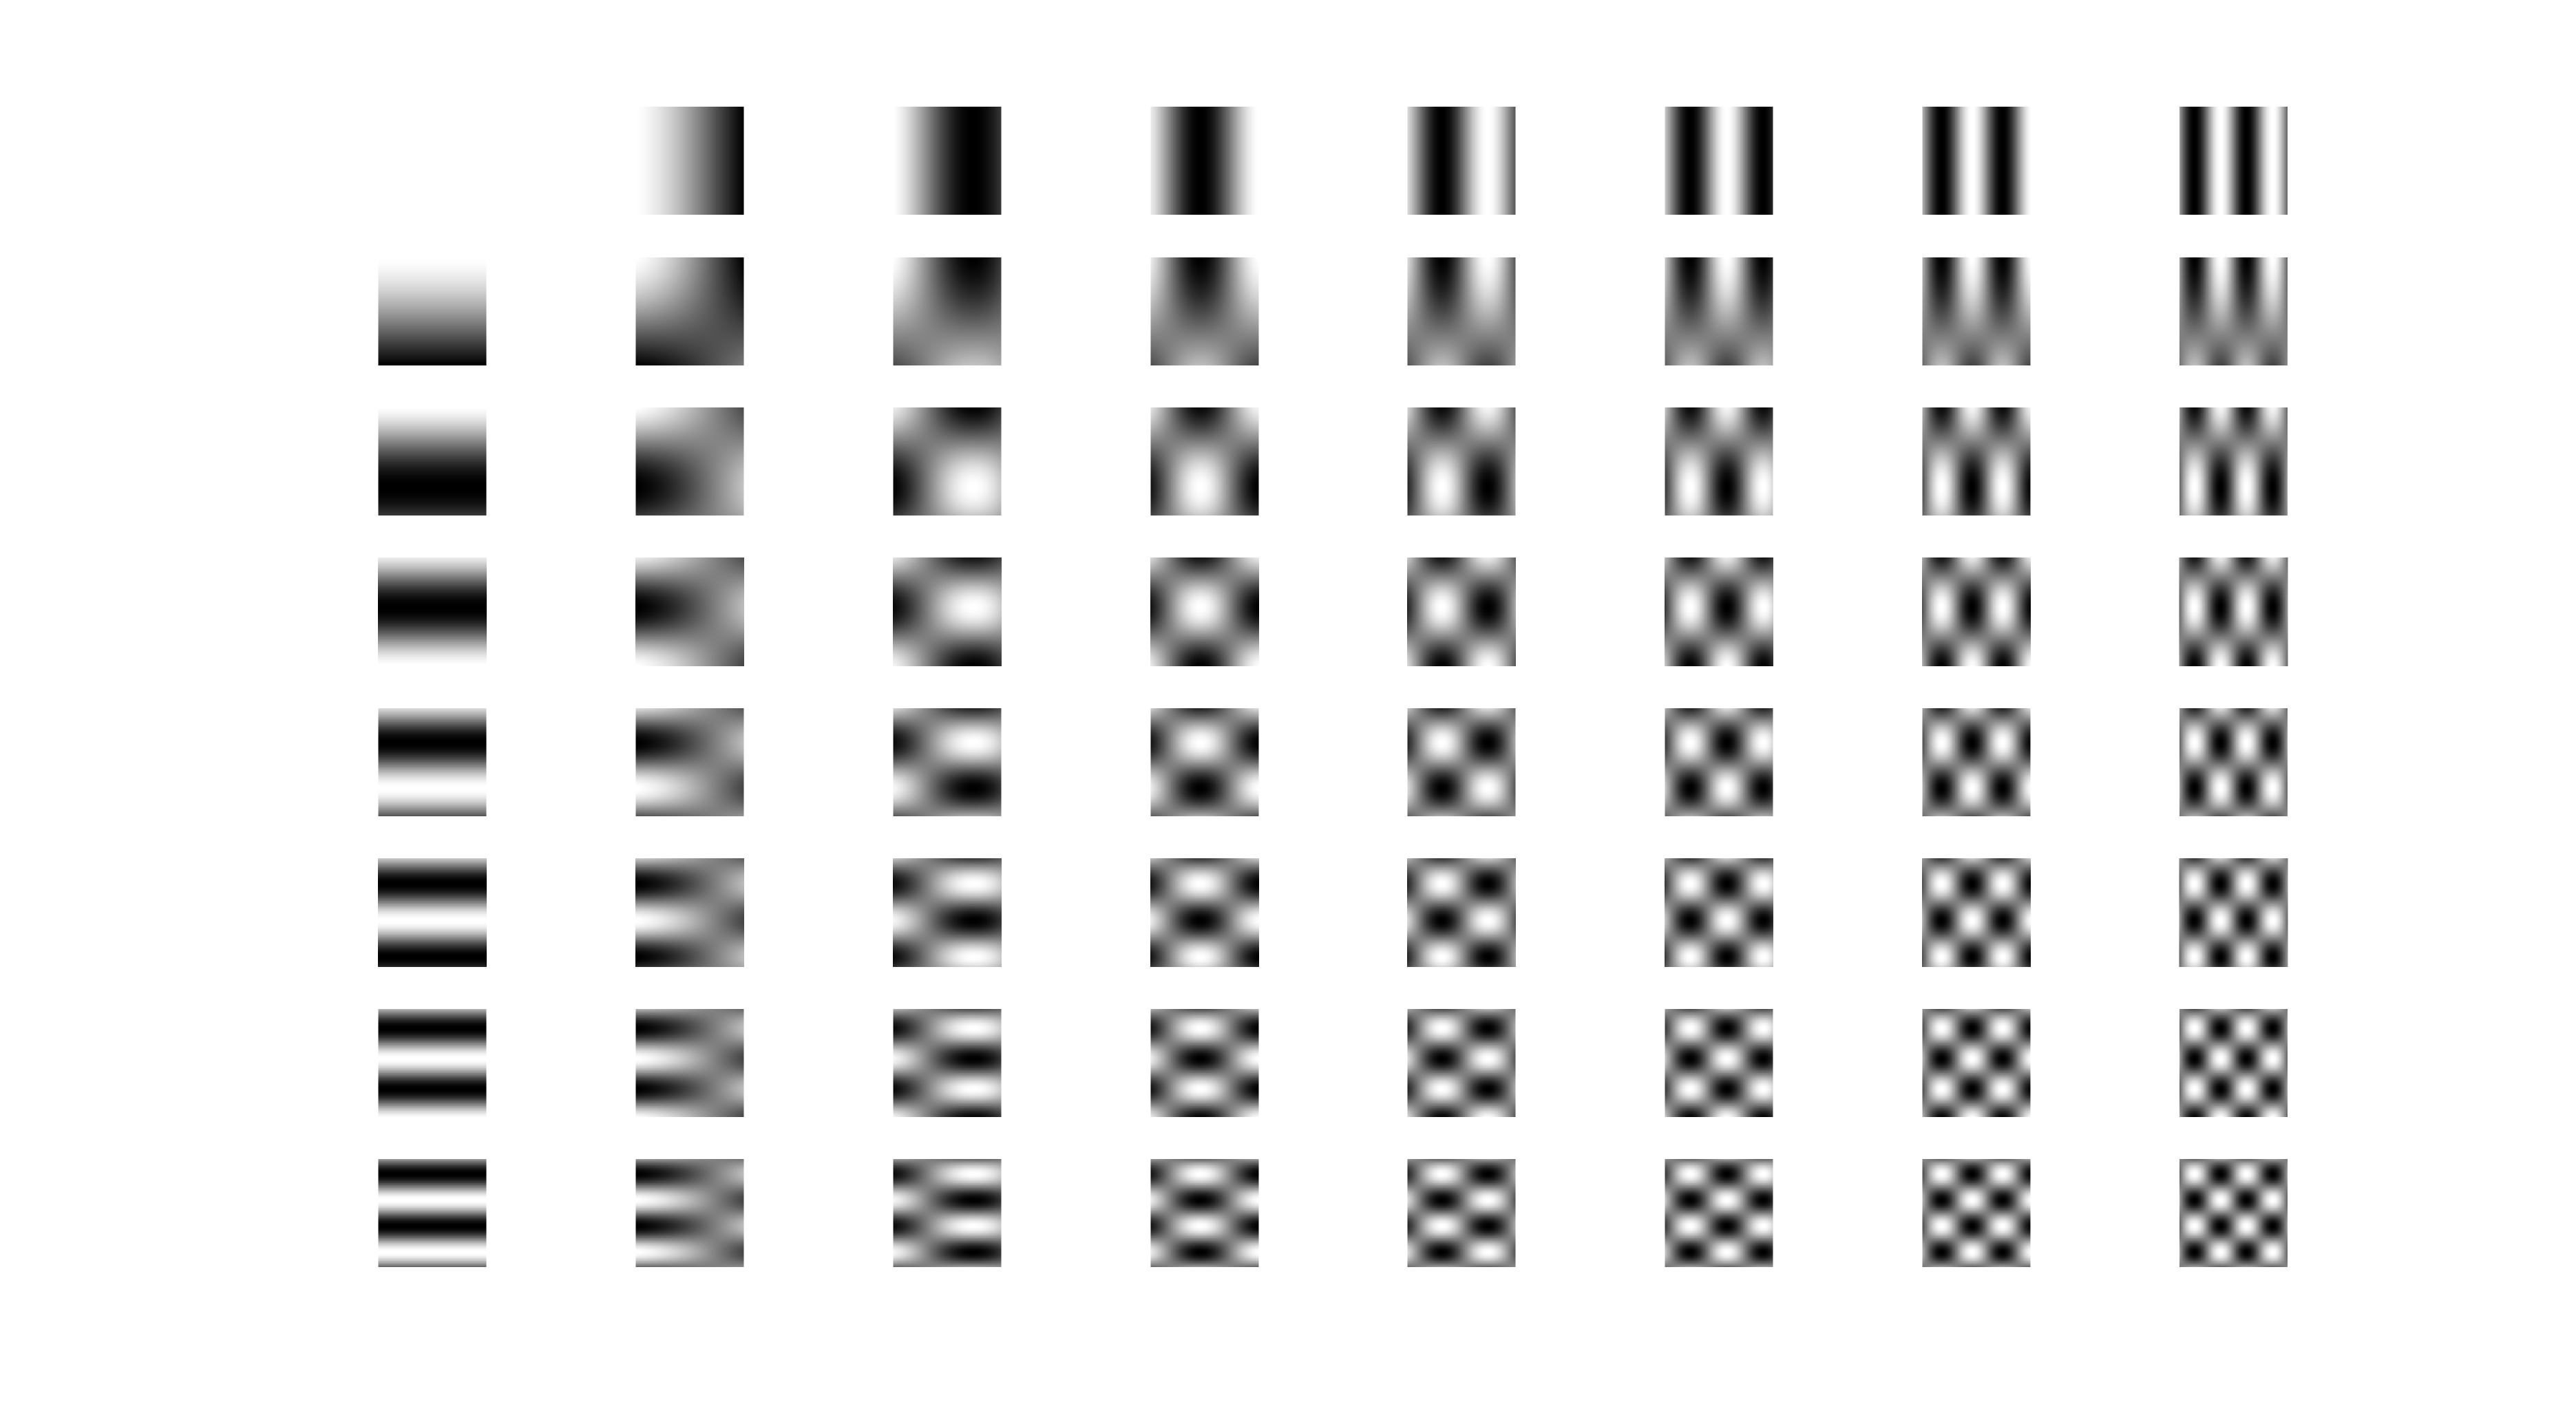

In [13]:
# TODO (+5 points)


c) <b>(10 points)</b> Reconstruct an image from 2D DCT coefficients. Write a ``reconstruct_image`` function that recieves an image (e.g. image <i>A.bmp</i>) as an input and calculates its 2D DCT. Then, add up the cosines multiplied with the appropriate coefficients. <b>Visualize the reconstructed image at each step.</b> Comment on the contribution of lower and higher frequency components to the recognizability of the image. Which frequencies are more important?

In [14]:
def reconstruct_image(input_image):
    # TODO (+10 points)
    pass

In [15]:
imageA = io.imread("images/A.bmp")

## Assignment 3: JPEG Pipeline

In this assignment you will implement the main part of the JPEG compression algorithm. The image needs to be split into $8 \times8$ blocks and DCT must be performed on each of them. The coefficients are then quantized using a quantization matrix. The result is finally losslessly compressed using entropy encoding.

a) Use the provided ```quantization_matrix``` function to generate different quantization matrices. The function accepts an argument on the interval $[1,100]$ which can be interpreted as the output image quality in percentages. How does the matrix change with different inputs? Experiment with a few values.

In [16]:
# Generation of different quality quantization matrices, based on detail level
def quantization_matrix(alpha_image_quality):    
    
    # For this example we use the standard quantization matrix proposed by the Independent JPEG Group (IJG)
    Q = np.array([[16,  11,  10,  16,  24,  40,  51,  61],
                  [12,  12,  14,  19,  26,  58,  60,  55],
                  [14,  13,  16,  24,  40,  57,  69,  56],
                  [14,  17,  22,  29,  51,  87,  80,  62],
                  [18,  22,  37,  56,  68, 109, 103,  77],
                  [24,  35,  55,  64,  81, 104, 113,  92],
                  [49,  64,  78,  87, 103, 121, 120, 101],
                  [72,  92,  95,  98, 112, 100, 103,  99]])
    
    if(alpha_image_quality < 50):
        s = 5000 / alpha_image_quality
    else:
        s = 200 - 2 * alpha_image_quality
    
    R = np.floor( (s * Q + 50) / 100 )
    R[R == 0] = 1
    
    return R

In [17]:
# TODO: Generate and print different quantization matrices

print(quantization_matrix(50))
print(quantization_matrix(30))
print(quantization_matrix(100))

[[ 16.  11.  10.  16.  24.  40.  51.  61.]
 [ 12.  12.  14.  19.  26.  58.  60.  55.]
 [ 14.  13.  16.  24.  40.  57.  69.  56.]
 [ 14.  17.  22.  29.  51.  87.  80.  62.]
 [ 18.  22.  37.  56.  68. 109. 103.  77.]
 [ 24.  35.  55.  64.  81. 104. 113.  92.]
 [ 49.  64.  78.  87. 103. 121. 120. 101.]
 [ 72.  92.  95.  98. 112. 100. 103.  99.]]
[[ 27.  18.  17.  27.  40.  67.  85. 102.]
 [ 20.  20.  23.  32.  43.  97. 100.  92.]
 [ 23.  22.  27.  40.  67.  95. 115.  93.]
 [ 23.  28.  37.  48.  85. 145. 133. 103.]
 [ 30.  37.  62.  93. 113. 182. 172. 128.]
 [ 40.  58.  92. 107. 135. 173. 188. 153.]
 [ 82. 107. 130. 145. 172. 202. 200. 168.]
 [120. 153. 158. 163. 187. 167. 172. 165.]]
[[1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]]


b) Split your input image into $8\times8$ blocks. Take care to pad the input image if its dimensions are not divisible by $8$ (use the ``np.pad`` function with <i>'edge'</i> padding mode to pad with the edge values of array).

For each of the blocks, do:
  * Subtract $128$ (take care of the data type)
  * Calculate the 2D DCT
  * Perform element-wise division by the quantization matrix $Q$
  * Round the coefficients to quantize them
  * Do element-wise multiplication with $Q$.
  * Save the quantized coefficients in a separate matrix
  * Calculate the 2D IDCT
  * Add $128$

Display the image reconstructed from quantized blocks. Display the difference to the original. Comment on the distribution of the differences and the reduction in image quality (try different levels of quantization).

<i><b>Note:</b></i> Do not use the image <i>A.bmp</i> from the previous assignment.

<i><b>Question:</b></i> Why is the image <i>A.bmp</i> a bad candidate for JPEG compression?

(354, 630)


<IPython.core.display.Javascript object>


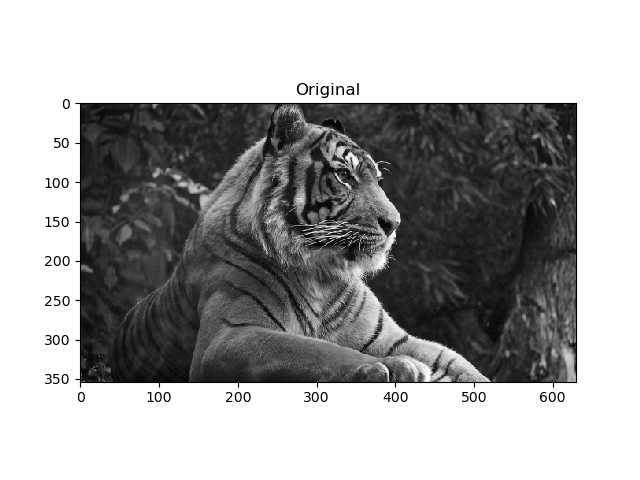

(360, 632)


<IPython.core.display.Javascript object>


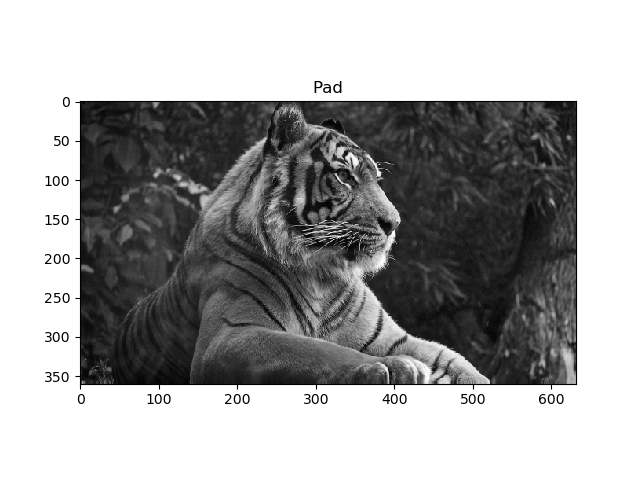

(354, 630)


<IPython.core.display.Javascript object>


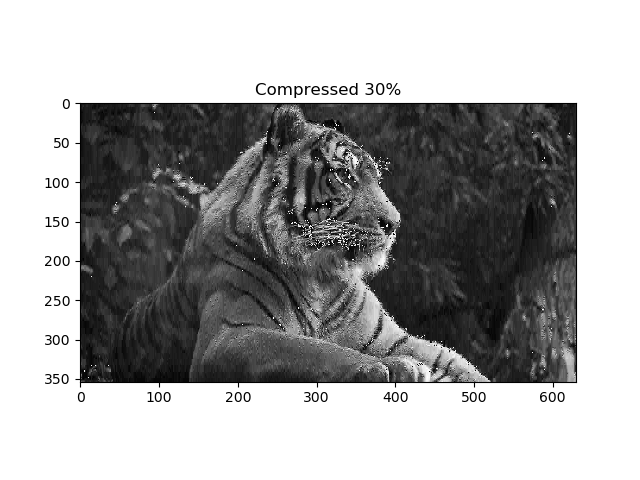

In [39]:

# TODO: Answer the question
tiger = io.imread("images/tiger.bmp")
tiger_gray = np.mean(tiger, 2).astype(np.uint8)
print(tiger_gray.shape)
plt.figure()
plt.imshow(tiger_gray.astype(np.uint8), cmap = plt.cm.gray)
plt.title("Original")

pad_h = 3
pad_w = 1 

paddana = np.pad(tiger_gray,((pad_h,pad_h),(pad_w,pad_w)), "edge")
print(paddana.shape)
im_h, im_w = paddana.shape

plt.figure()
plt.imshow(paddana.astype(np.uint8), cmap = plt.cm.gray)
plt.title("Pad")

window = 8
Q = quantization_matrix(20)
result= np.zeros([im_h+pad_h, im_w+pad_w])

for row in np.arange(im_h-window+1, step=window):
    for col in np.arange(im_w-window+1, step=window):
        blok = paddana[row:row+window, col:col+window]
        blok = blok - 128
        blok = my_dct2(blok)
        blok = np.divide(blok, Q)
        blok = np.round(blok)
        blok = np.multiply(blok, Q)
        #print(blok)
        result[row:row+window, col:col+window] = my_idct2(blok)

#koncno = idct2(result)
koncno = result + 128
final = koncno[pad_h:-2*pad_h, pad_w:-2*pad_w]
print(final.shape)

plt.figure()
plt.imshow(final.astype(np.uint8), cmap = plt.cm.gray)
plt.title("Compressed 30%")
plt.show()

c) Study the provided ``huffman_traversal`` function and use it to perform Huffman encoding of an arbitrary grayscale image (you can use the provided image <i>tiger.bmp</i>) and calculate the compression rate.

In [18]:
class Node:
    def __init__(self):
        # the color (the bin value) is only required in the leaves
        self.prob = None
        self.code = None
        self.data = None
        self.left = None
        self.right = None
    def __lt__(self, other):
        if (self.prob < other.prob):
            return 1
        else:
            return 0
    def __ge__(self, other):
        if (self.prob > other.prob):
            return 1
        else:
            return 0
        
def tree(probabilities):
    prq = queue.PriorityQueue()
    for color,probability in enumerate(probabilities):
        leaf = Node()
        leaf.data = color
        leaf.prob = probability
        prq.put(leaf)

    while (prq.qsize()>1):
        newnode = Node() # create new node
        l = prq.get()
        r = prq.get() # get the smalles probs in the leaves

        # remove the smallest two leaves
        newnode.left = l # left is smaller
        newnode.right = r
        newprob = l.prob+r.prob # the new prob in the new node must be the sum of the other two
        newnode.prob = newprob
        prq.put(newnode) # new node is inserted as a leaf, replacing the other two 
    return prq.get() # return the root node - tree is complete

def huffman_traversal(root_node,tmp_array,f): # traversal of the tree to generate codes
    if (root_node.left is not None):
        tmp_array[huffman_traversal.count] = 1
        huffman_traversal.count+=1
        huffman_traversal(root_node.left,tmp_array,f)
        huffman_traversal.count-=1
    if (root_node.right is not None):
        tmp_array[huffman_traversal.count] = 0
        huffman_traversal.count+=1
        huffman_traversal(root_node.right,tmp_array,f)
        huffman_traversal.count-=1
    else:
        huffman_traversal.output_bits[root_node.data] = huffman_traversal.count #count the number of bits for each color
        bitstream = ''.join(str(cell) for cell in tmp_array[1:huffman_traversal.count]) 
        color = str(root_node.data)
        wr_str = color+' '+ bitstream+'\n'
        f.write(wr_str) # write the color and the code to a file
    return

<IPython.core.display.Javascript object>


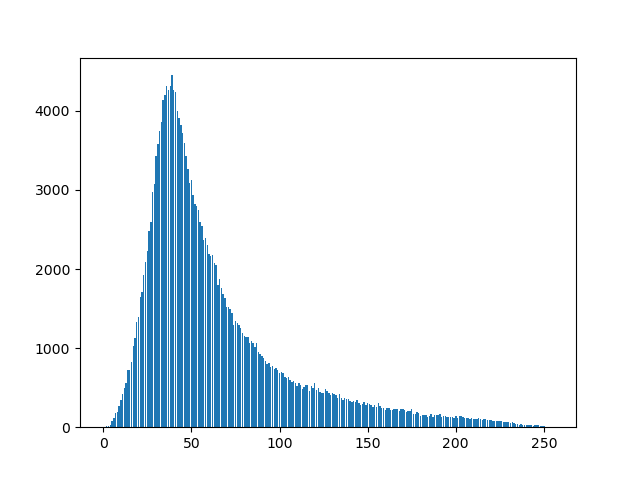

0.24437550443906375


In [20]:
# TODO:
from skimage.exposure import histogram

# 1) Read an image, convert it to grayscale and cast as int
tiger = io.imread("images/tiger.bmp")
tiger_bw = np.mean(tiger, 2).astype(np.uint8)
im_h, im_w = tiger_bw.shape
# 2) Compute the histogram (hist) of pixels
plt.figure()
hvalues, hbins = histogram(tiger_bw, nbins=256, source_range='dtype', normalize=False)
plt.bar(hbins, hvalues)
# 4) Calculate a priori probabilities from frequencies (hist / np.sum(hist))
probabilities = hvalues/np.sum(hvalues)
# 5) Create a tree using the computed probabilities
root_node = tree(probabilities)

# Initialization
tmp_array = np.ones([64],dtype=int)
huffman_traversal.output_bits = np.empty(256,dtype=int) 
huffman_traversal.count = 0
f = open('codes.txt','w')

# 6) Traverse the tree and write the codes in .txt file (use function "huffman_traversal")
huffman_traversal(root_node,tmp_array,f)
# 7) Calculate the compression rate and display it (in percentages)
codes = open('codes.txt','r')
lines =  codes.read().splitlines() 
tabela = dict()
vsota = 0
for line in lines:
    a, b = line.split(' ')
    tabela[int(a)] = len(b)

for i in hbins:
    vsota += hvalues[i] * tabela[i]
    

vsotaStaro = np.sum(hvalues) * 8
razmerje = 1 - vsota/vsotaStaro
print(razmerje)

f.close() # Close file writer

d) <b>(10 points)</b> Modify the above code to compress the entire matrix of quantized coefficients. Comment on the compression ratio for different levels of quantization. 

<i><b>Question:</b></i> Why can quantized images be stored using less space?

In [40]:
# TODO (+10 points)
print(final.max())
# 1) Read an image, convert it to grayscale and cast as int
im_h, im_w = final.shape
# 2) Compute the histogram (hist) of pixels
plt.figure()
hvalues, hbins = histogram(final, normalize=False)
plt.bar(hbins, hvalues)


# TODO (+10 points)
# TODO:
from skimage.exposure import histogram


# 1) Read an image, convert it to grayscale and cast as int
tiger_gray = final.astype(np.uint8)
im_h, im_w = final.shape
# 2) Compute the histogram (hist) of pixels
plt.figure()
hvalues, hbins = histogram(tiger_gray, nbins=256, source_range='dtype', normalize=False)
plt.bar(hbins, hvalues)
# 4) Calculate a priori probabilities from frequencies (hist / np.sum(hist))
probabilities = hvalues/np.sum(hvalues)
# 5) Create a tree using the computed probabilities
root_node = tree(probabilities)

# Initialization
tmp_array = np.ones([64],dtype=int)
huffman_traversal.output_bits = np.empty(1024,dtype=int) 
huffman_traversal.count = 0
f = open('codes1.txt','w')

# 6) Traverse the tree and write the codes in .txt file (use function "huffman_traversal")
huffman_traversal(root_node,tmp_array,f)
f.close()
# 7) Calculate the compression rate and display it (in percentages)
codes = open('codes1.txt','r')
lines =  codes.read().splitlines() 
tabela = dict()
vsota = 0
for line in lines:
    a, b = line.split(' ')
    tabela[int(a)] = len(b)

for i in hbins:
    vsota += hvalues[i] * tabela[i]
    #print(i,": ", hvalues[i], "*", tabela[i], "=", hvalues[i] * tabela[i], "=>", vsota)

vsotaStaro = np.sum(hvalues) * 8
razmerje = 1 - vsota/vsotaStaro
print(razmerje)
f.close() # Close file writer

# Question: Why can quantized images be stored using less space?
# ANSWER:
# Quantized images have more pixels of the same value, so huffman encoding is even more effective as on a normal image.

469.62031223849306


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

IndexError: index 1039 is out of bounds for axis 0 with size 1024

e) <b>(10 points)</b> Convert the image into YCbCr color space, then subsample the color channels and reconstruct the image. Find representative images and comment on the difference using different magnitudes of subsampling. Do the same with the $Y$ channel. Use your JPEG implementation to compress a multi-channel image. Try compressing in YCbCr by subsapling color channels. How does that affect the compression ratio?

In [ ]:
# TODO (+10 points)